In [1]:
import tensorflow as tf
from src.data.data_helper import get_raw_data_as_dataframe
import matplotlib.pyplot as plt

In [2]:
raw_data = get_raw_data_as_dataframe()

In [3]:
raw_data.head()

,time,measurement,label,source
0,0.0000,1.610419,0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
1,0.0002,1.610419,0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
2,0.0004,1.610419,0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
3,0.0006,1.610419,0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
4,0.0008,1.610419,0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...


In [37]:
from scipy.signal import butter, sosfiltfilt

def butter_bandpass(lowcut, highcut, fs=5000, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', output='sos')
    return sos

FILT_SOS = butter_bandpass(20., 500., 5000, order=7)

def butter_bandpass_filter(data):
    y = sosfiltfilt(FILT_SOS, data)
    return y

# wrap numpy-based function for use with TF
@tf.function(input_signature=[tf.TensorSpec(None, tf.float64)])
def tf_bp_filter(input):
    y = tf.numpy_function(butter_bandpass_filter, [input], tf.float64)
    return y

def pre_processor_layer(x):
    b = [0.00419699, 0, -0.01678797, 0, 0.02518196, 0, -0.01678797, 0, 0.00419699]
    a = [1,  -6.38164673, 17.89924864,-28.87732286, 29.35610903, -19.27287096, 7.98121461, -1.90559965, 0.20086794]

    # Bandpass 20-500 Hz (also test using signal.lfilter)
    x = tf_bp_filter(x)

    # Absolute value
    x = tf.abs(x)

    # Moving average 10 samples
    x = tf.signal.frame(x, frame_length=200, frame_step=1)
    x = tf.reduce_mean(x, axis=1)

    x = tf.keras.layers.Normalization(mean=0, variance= 0.004683887229275346)(x)

    return x

In [38]:
from src.utils.path_utils import get_raw_data_dir
import glob

# List all csv files
csv_files = glob.glob(str(get_raw_data_dir()) + "/Dataset_O1/**/*.csv", recursive=True)

In [39]:
# Select a sample signal (replace 'column_name' with your actual column)
single_file = raw_data[raw_data['source'] == csv_files[30]]
sample_signal = single_file['measurement'].values

In [40]:
sample_signal.shape

(170000,)

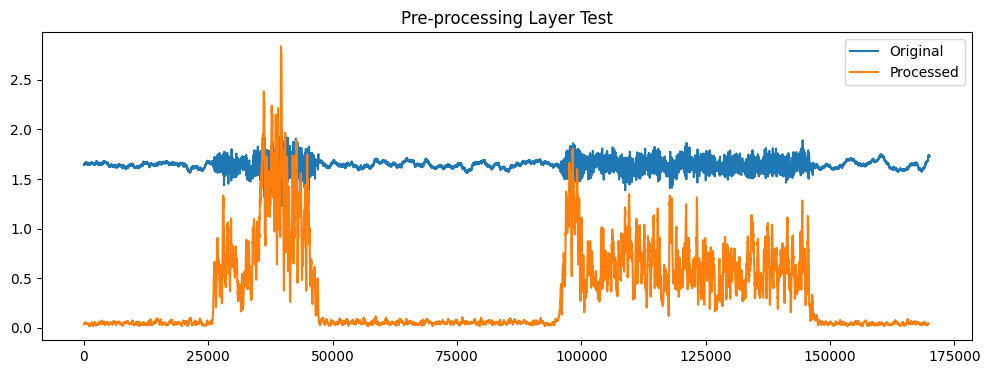

In [41]:
processed_signal = pre_processor_layer(sample_signal)

# Plot original vs processed
plt.figure(figsize=(12, 4))
plt.plot(sample_signal, label='Original')
plt.plot(processed_signal, label='Processed')
plt.legend()
plt.title('Pre-processing Layer Test')
plt.show()

In [42]:
from src.models.model_components.preprocessor import calibrate_pre_processor

TypeError: input_signature missing type constraint for sos

In [10]:
sos, variance = calibrate_pre_processor(raw_data)

print(f"sos: {sos}")
print(f"variance: {variance}")

a: [  1.          -6.38164673  17.89924864 -28.87732286  29.35610903
 -19.27287096   7.98121461  -1.90559965   0.20086794]
b: [ 0.00419699  0.         -0.01678797  0.          0.02518196  0.
 -0.01678797  0.          0.00419699]
variance: 0.004675060976296663
